In [1]:
# Tabular Data
import pandas as pd
import numpy as np

# .py files with custom functions
import wrangle
import explore
# import modeling

# suppress warning notifications
import warnings
warnings.filterwarnings("ignore")

# Scaling, clustering, and modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# Clustering Project - Estimating LogError in Zillow dataset


## Project Overview and Goals

<div class="alert alert-block alert-success">
<b><font size="+1">The purpose of this project is to create a Regression Model using clustering that predicts the zillow model log error of Single Family Properties that were sold in 2017 from a database of Zillow data.   
<br><br>
    
    
Goal 1: 
<br>
    Goal 2: <br>
    Goal 3: 

<hr style="border:10px solid blue">


## Wrangle:  Acquire and Prepare Data

In [2]:
# acquire zillow data
df = wrangle.get_zillow()
df.head()


,parcelid,bathrooms,bedrooms,sqft,county,latitude,garagesqft,longitude,lotsize,tract,regionidzip,yearbuilt,structuretaxvalue,propertylandusedesc,landtaxvalue,taxamount,logerror
0,12826780,2.0,3.0,1762.0,6037.0,33937685.0,NaN,-117996709.0,6347.0,6.037503e+07,96171.0,1955.0,140000.0,Single Family Residential,382000.0,6317.15,0.007204
1,17239384,2.0,4.0,1612.0,6111.0,34300140.0,560.0,-118706327.0,12105.0,6.111008e+07,97116.0,1964.0,50683.0,Single Family Residential,16522.0,1107.48,0.013209
2,12773139,1.0,3.0,1032.0,6037.0,34040895.0,NaN,-118038169.0,5074.0,6.037434e+07,96480.0,1954.0,32797.0,Single Family Residential,16749.0,876.43,0.037129
3,11000655,2.0,2.0,1286.0,6037.0,34245368.0,NaN,-118282383.0,47405.0,6.037101e+07,96284.0,1940.0,70917.0,Single Family Residential,283704.0,4478.43,0.020615
4,12768500,3.0,4.0,1732.0,6037.0,34044346.0,NaN,-118002920.0,3087.0,6.037408e+07,96490.0,2003.0,157572.0,Single Family Residential,208737.0,4802.63,0.014142


In [3]:
# prepare zillow data
df = wrangle.prep_zillow(df)
# remove outliers
df = wrangle.remove_outliers(df)

<div class="alert alert-block alert-success">
<b><font size="+2">Prepare takeaways:  
<br><br>
    
<font size="+1">   
    <u>Missing Data:  </u>  Nulls replaced with zeros<br><br>
    <u>Conversions:  </u>FIPS to county (and one-hot encoded), latitude and logitude put in proper decimal format, year built converted to age, nulls to zeros where appropriate<br><br>
    <u>Removed rows:  </u>Those with remaining null values, rows with invalid zip code, homes with no bedrooms, and homes where the home was larger than the lot<br><br>
    <u>Created columns:  </u>'abserror', the absolute value of logerror; 'dollarspersqft', the taxvalue / the area<br><br>
    <u>Removed outliers:  </u> Rows with values more than 1.5 times the interquartile range from the quartiles were removed

In [4]:
df.head().T

,0,1,2,4,5
parcelid,12826780,17239384,12773139,12768500,12808835
bathrooms,2.0,2.0,1.0,3.0,2.0
bedrooms,3.0,4.0,3.0,4.0,3.0
sqft,1762.0,1612.0,1032.0,1732.0,1116.0
county,Los Angeles,Ventura,Los Angeles,Los Angeles,Los Angeles
latitude,33.937685,34.30014,34.040895,34.044346,34.044604
garagesqft,0.0,560.0,0.0,0.0,0.0
longitude,-117.996709,-118.706327,-118.038169,-118.00292,-117.974827
lotsize,6347.0,12105.0,5074.0,3087.0,6153.0
tract,60375034.02102,61110084.022016,60374338.022005,60374083.021017,60374071.022004


<hr style="border:10px solid blue">


## Data Exploration

### What does our target variable, logerror, look like?

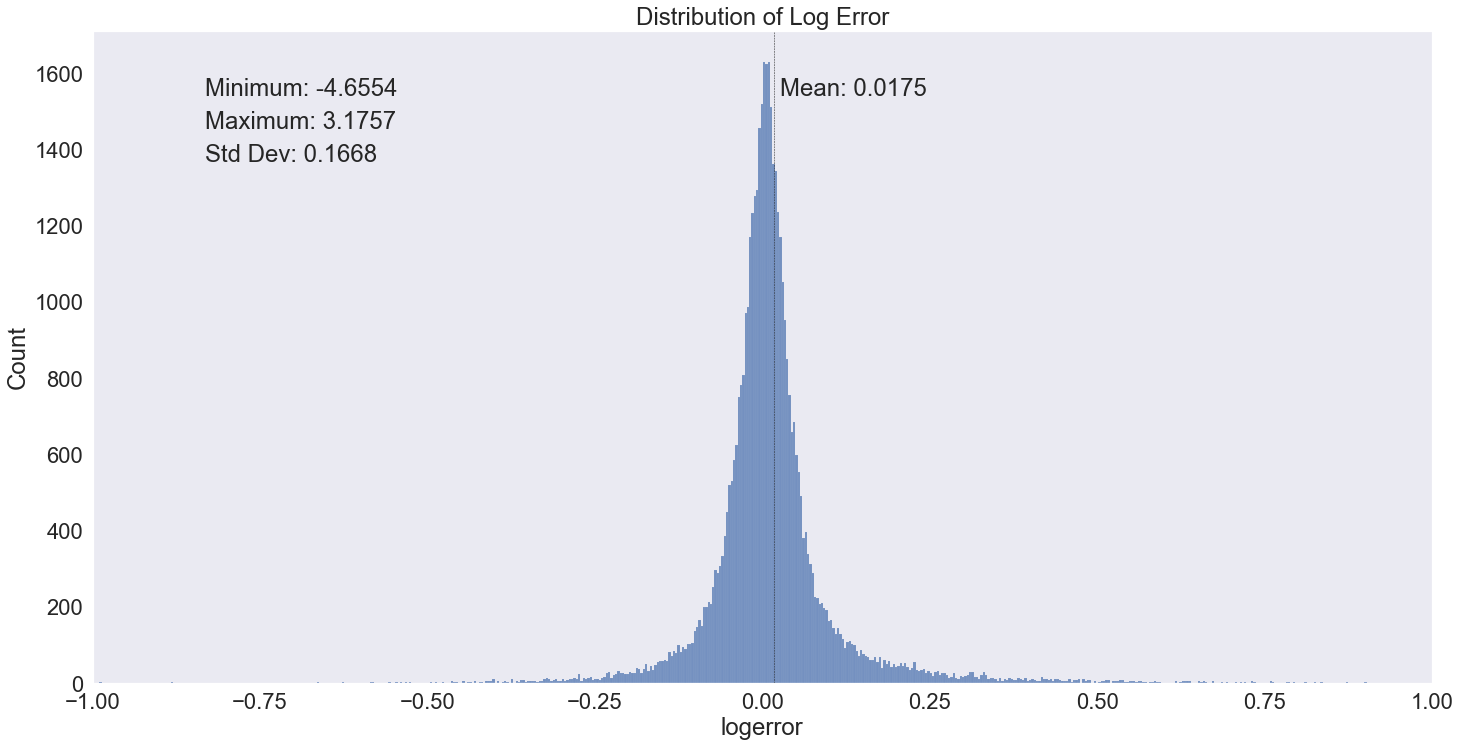

In [5]:
# test target variable distribution plot
explore.target_dist(df)

### Takeaways

- Logerror is normally distributed
- Mean is slightly positive
- Some significant outliers
- The mean will be close to zero, so will use abserror at times in exploration

In [6]:
### Split data into 60% train, 20% validate, and 20% test
train, validate, test = wrangle.my_split(df)

## Is the Log Error Different in each county?

### H0: Average Log Error of the properties in three counties (Los Angeles, Ventura, and Orange) are all equal.

### Ha: Average Log Error of the properties in three counties (Los Angeles, Ventura, and Orange) are NOT all equal

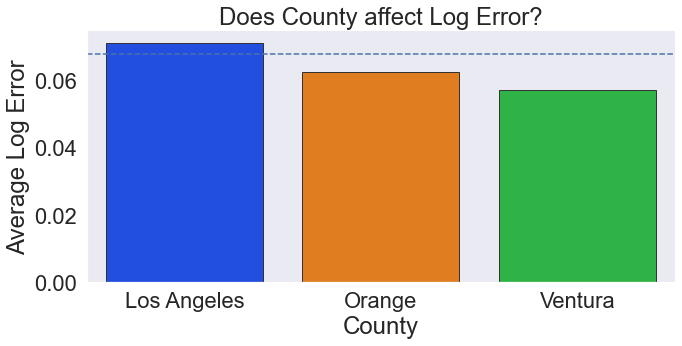

Average logerror of those in Los Angeles County is  0.07
Average logerror value of those in Ventura County is 0.06
Average logerror value of those in Orange County is 0.06


We reject the Null Hypothesis


In [7]:
# plot and perform ANOVA test
explore.county_plot(train)

####  Average Log Error of the properties in three counties (Los Angeles, Ventura, and Orange) are NOT all equal.  There is more error in the predictions in Los Angeles County

## Does lot size impact log error?

### H0: Log Error of small lots is equal to Log Error of all properties

### Ha: Log Error of small lots is significantly different than Log Error of all properties 

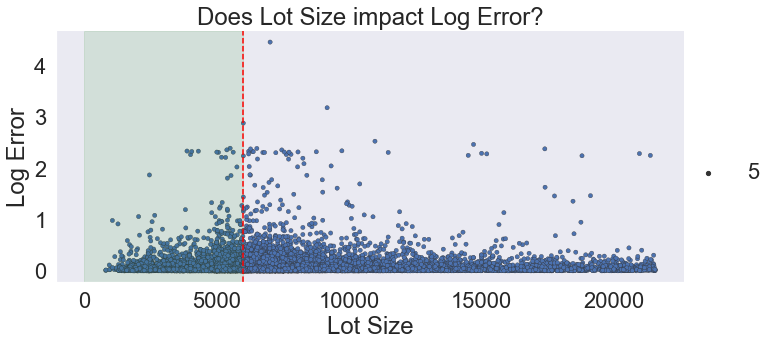

Average logerror of small properties  0.0646
Average logerror of all properties  0.0678


We reject the Null Hypothesis
0.02564652900832558


In [8]:
# plot and perform Independent T-Test
explore.lotsize_plot(train)

####  Average Log Error of small properties is significantly different, but it looks like there may be some optimal ranges for binning or clustering